Retrieve calendar data

In [237]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import timedelta

# path to parent folder with subfolder for each of the 4 scrapes (retained structure from what Sakshi uploaded to Google drive)
path = 'C:/Users/Immig/Documents/DSBA-6211/Project_Airbnb/data/'

In [240]:
def filter_listings(df_c, min_nights, min_avail, scrape):
    
    unique = len(df_c['listing_id'].unique())
    print(f'{scrape}: Unique listings before filtering: {unique}')

    # remove all days where the minimum nights is more than min_nights
    df_c = df_c[df_c['minimum_nights'] <=min_nights]

    df_agg = df_c.groupby('listing_id', as_index=False).agg({
        'date': ['min', 'max', 'count'], 
        'available': 'mean',
        'price': 'mean'})
    
    df_agg.columns = ['listing_id', 'min_date', 'max_date', 'count_date', 'avg_avail', 'avg_price']
    df_agg['avg_booked'] = 1-df_agg['avg_avail']

    df_agg['days_avail'] = (df_agg['avg_avail']*df_agg['count_date']).astype('int')
    df_agg = df_agg[df_agg['days_avail'] >= min_avail]


    unique = len(df_agg)
    print(f'{scrape}: Unique listings after filtering: {unique}\n')

    df_filtered = df_c[df_c['listing_id'].isin(list(df_agg['listing_id']))]


    return df_filtered, df_agg

def fix_values(df_c):
    df_c['date'] = df_c['date'].astype('datetime64')
    df_c['price'] = df_c['price'].str.extract(pat='(\d*\.\d*)').round(decimals=2).astype('float64')
    df_c['adjusted_price'] = df_c['adjusted_price'].str.extract(pat='(\d*\.\d*)').round(decimals=2).astype('float64')
    df_c['available'] = df_c['available'].apply(lambda x: 1 if x=='t' else 0)

    return df_c

def get_calendar(days_after_scrape, min_nights, min_avail):
    print('Data to retain:')
    print(f'Time window each scrape\t\t\t\t{days_after_scrape} days: ')
    print(f'Maximum value allowed for minimum_nights\t{min_nights} nights')
    print(f'Minimum days available (each scrape)\t\t{min_avail} day(s)\n\n')


    df_c1 = pd.read_csv(path + '2021-12-17/calendar.csv')
    df_c1 = fix_values(df_c1)
    #df_c1['date'] = df_c1['date'].astype('datetime64')
    df_c1 = df_c1[df_c1['date']<=(df_c1['date'].min() + timedelta(days=days_after_scrape))]
    df_c1, _ = filter_listings(df_c1, min_nights, min_avail, 'Scrape 1')

    df_c2 = pd.read_csv(path + '2022-03-20/calendar.csv')
    df_c2 = fix_values(df_c2)
    #df_c2['date'] = df_c2['date'].astype('datetime64')
    df_c2 = df_c2[df_c2['date']<=(df_c2['date'].min() + timedelta(days=days_after_scrape))]
    df_c2, _ = filter_listings(df_c2, min_nights, min_avail, 'Scrape 2')

    df_c3 = pd.read_csv(path + '2022-06-13/calendar.csv')
    df_c3 = fix_values(df_c3)
    #df_c3['date'] = df_c3['date'].astype('datetime64')
    df_c3 = df_c3[df_c3['date']<=(df_c3['date'].min() + timedelta(days=days_after_scrape))]
    df_c3, _ = filter_listings(df_c3, min_nights, min_avail, 'Scrape 3')

    df_c4 = pd.read_csv(path +'2022-09-15/calendar.csv')
    df_c4 = fix_values(df_c4)
    #df_c4['date'] = df_c4['date'].astype('datetime64')
    df_c4 = df_c4[df_c4['date']<=(df_c4['date'].min() + timedelta(days=days_after_scrape))]
    df_c4, _ = filter_listings(df_c4, min_nights, min_avail, 'Scrape 4')

    df_calendar = pd.concat([df_c1, df_c2, df_c3, df_c4], axis=0)



    # with overlapping days_after_scrape, remove duplicates
    df_calendar.drop_duplicates(subset=['listing_id','date'],inplace=True,ignore_index=True,keep='last')


    _, df_agg = filter_listings(df_calendar, min_nights, min_avail, 'All scrapes')
    df_agg = df_agg.set_index(df_agg['listing_id']).drop(columns=['listing_id'])

    return df_calendar, df_agg

df_calendar, df_calendar_agg = get_calendar(60, 3, 1)

Data to retain:
Time window each scrape				60 days: 
Maximum value allowed for minimum_nights	3 nights
Minimum days available (each scrape)		1 day(s)


Scrape 1: Unique listings before filtering: 6358
Scrape 1: Unique listings after filtering: 4688

Scrape 2: Unique listings before filtering: 6798
Scrape 2: Unique listings after filtering: 5005

Scrape 3: Unique listings before filtering: 7242
Scrape 3: Unique listings after filtering: 5585

Scrape 4: Unique listings before filtering: 7732
Scrape 4: Unique listings after filtering: 5974

All scrapes: Unique listings before filtering: 7508
All scrapes: Unique listings after filtering: 7508



In [241]:
# listings to keep and metrics for the time windows after each scrape
df_calendar_agg.head()

,min_date,max_date,count_date,avg_avail,avg_price,avg_booked,days_avail
listing_id,,,,,,,
39870,2021-12-17,2022-11-14,244,0.368852,66.790984,0.631148,90
72906,2021-12-17,2022-11-14,244,0.319672,102.237705,0.680328,78
329997,2021-12-17,2022-11-14,243,0.251029,110.600823,0.748971,61
395889,2021-12-17,2022-11-14,244,0.442623,92.192623,0.557377,108
421290,2021-12-17,2022-11-14,182,0.236264,104.307692,0.763736,43


In [319]:
df_listings = pd.concat([pd.read_csv(path + '2021-12-17/listings.csv'),
                pd.read_csv(path + '2022-03-20/listings.csv'),
                pd.read_csv(path + '2022-06-13/listings.csv'),
                pd.read_csv(path + '2022-09-15/listings.csv')], axis = 0 , ignore_index=True)

df_listings.drop_duplicates(subset=['id'],inplace=True,ignore_index=True,keep='last')
len(df_listings)

9610

In [ ]:
print(df_listings.columns)

In [320]:
# inital filtering based on calendar availability
df_listings = df_listings[df_listings['id'].isin(df_calendar_agg.index)]
len(df_listings)

7508

In [321]:
df_listings = df_listings[~df_listings['first_review'].isnull()]
len(df_listings)

6806

In [322]:
# for listings with no reviews, add dummy values for first & last review 
#df_listings['first_review'] = df_listings['first_review'].fillna(value=pd.to_datetime('1/2/1989'))
#df_listings['last_review'] = df_listings['last_review'].fillna(value=pd.to_datetime('1/1/1989'))

df_listings['days_with_reviews'] = (pd.to_datetime(df_listings['last_review']) - pd.to_datetime(df_listings['first_review'])).dt.days

#print('Number of listings with 0 reviews:', len(df_listings[df_listings['days_with_reviews']==-1]))
print('Number of listings with 1 review:', len(df_listings[df_listings['days_with_reviews']==0]))

Number of listings with 1 review: 306


In [323]:
# a minimum number for 'days_with_reviews' is specified to penalize new listings without a "proven" track record
df_listings['days_with_reviews'] = df_listings['days_with_reviews'].apply(lambda x:180 if x < 180 else x)

# reviews per day is calculated using either the actual number of days between first & last review, OR the assigned minimum value of 30
df_listings['reviews_per_day'] = df_listings['number_of_reviews']/df_listings['days_with_reviews']

# remove listings with suspiciously many reviews
df_listings = df_listings[df_listings['reviews_per_day'] < 1]

df_listings['review_freq_dv'] = np.log(df_listings['reviews_per_day']+1)/np.log(df_listings['reviews_per_day']+1).max()
len(df_listings)

6802

In [324]:
df_combined = df_listings.join(df_calendar_agg, on='id', how='inner')

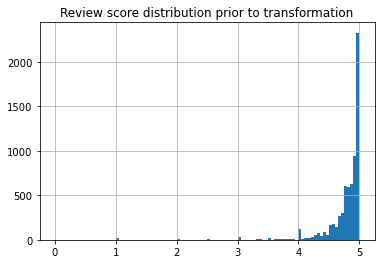

In [326]:
plt.figure(1)
df_combined['review_scores_rating'].hist(bins=100)
plt.title('Review score distribution prior to transformation')

# stretch the review score distribution at the top end
df_combined['review_score_dv'] = np.power(5,df_combined['review_scores_rating'])
df_combined['review_score_dv'] = df_combined['review_score_dv']/df_combined['review_score_dv'].max()

Text(0.5, 0, 'Days with reviews')

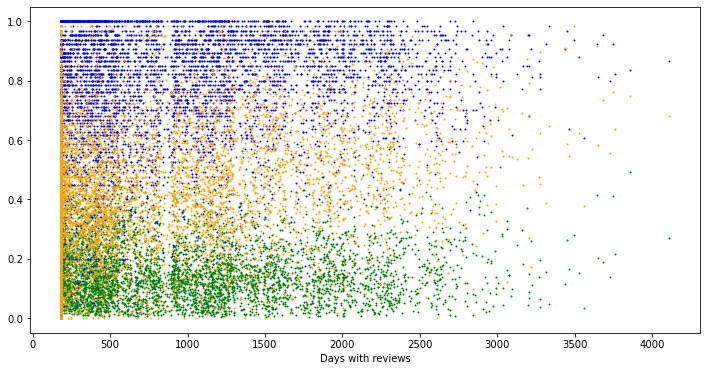

In [332]:
fig = plt.figure(figsize=(12,6))

plt.scatter(df_combined['days_with_reviews'],df_combined['review_freq_dv'], 1, c='green')
plt.scatter(df_combined['days_with_reviews'],df_combined['review_score_dv'], 1, c='blue')
plt.scatter(df_combined['days_with_reviews'],df_combined['avg_booked'], 1, c='orange')
plt.xlabel('Days with reviews')

In [333]:
df_combined[['review_freq_dv', 'review_score_dv', 'avg_booked']].describe()

,review_freq_dv,review_score_dv,avg_booked
count,6802.000000,6802.000000,6802.000000
mean,0.141340,0.771393,0.440992
std,0.110300,0.228713,0.217484
min,0.003636,0.000320,0.000000
25%,0.055616,0.658063,0.290695
50%,0.117838,0.837748,0.430328
75%,0.199338,0.952864,0.588477
max,1.000000,1.000000,0.983607


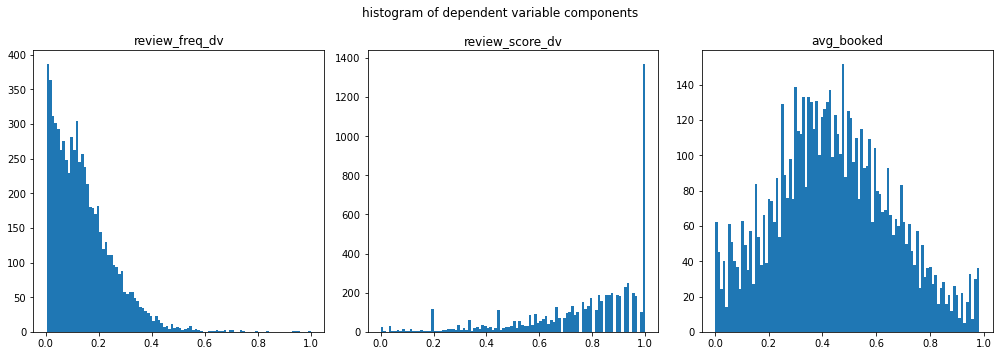

In [354]:
# Create two subplots and unpack the output array immediately
fig, ax = plt.subplots(1, 3, figsize=(14,5), sharey=False)
fig.suptitle('histogram of dependent variable components')
ax[0].set_title('review_freq_dv')
ax[0].hist(df_combined['review_freq_dv'],bins=100)
ax[1].set_title('review_score_dv')
ax[1].hist(df_combined['review_score_dv'],bins=100)
ax[2].set_title('avg_booked')
ax[2].hist(df_combined['avg_booked'],bins=100)

fig.tight_layout()


<AxesSubplot:>

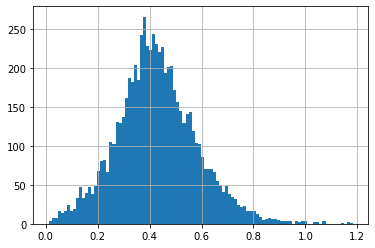

In [346]:
wght_review_freq= 1
wght_review_score = 0.2
wght_bookings = 0.3

df_combined['dep_candidate'] = wght_review_freq*df_combined['review_freq_dv'] + wght_review_score * df_combined['review_score_dv'] + wght_bookings * df_combined['avg_booked']
df_combined['dep_candidate'].hist(bins=100)

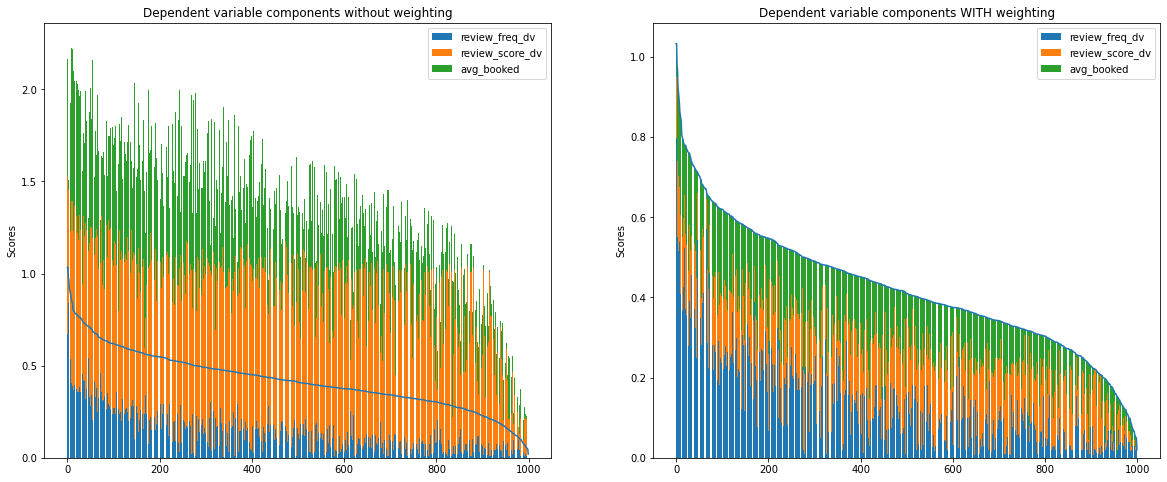

In [356]:
alpha = 1
sample = df_combined.sample(n=1000)
sample = sample.sort_values('dep_candidate', ascending=False)
sample = sample.reset_index()

fig, ax = plt.subplots(1, 2, figsize=(20,8))
labels = [val for val in sample.index]

ax[0].plot(labels, sample['dep_candidate'])
ax[0].bar(labels, sample['review_freq_dv'], label='review_freq_dv', alpha=alpha)
ax[0].bar(labels, sample['review_score_dv'], bottom=sample['review_freq_dv'], label='review_score_dv', alpha=alpha)
ax[0].bar(labels, sample['avg_booked'], bottom=sample['review_score_dv']+sample['review_freq_dv'], label='avg_booked', alpha=alpha)

ax[0].set_ylabel('Scores')
ax[0].set_title('Dependent variable components without weighting')
ax[0].legend()

ax[1].plot(labels, sample['dep_candidate'])
ax[1].bar(labels, wght_review_freq*sample['review_freq_dv'], label='review_freq_dv', alpha=alpha)
ax[1].bar(labels, wght_review_score*sample['review_score_dv'], bottom=wght_review_freq*sample['review_freq_dv'], label='review_score_dv', alpha=alpha)
ax[1].bar(labels, wght_bookings*sample['avg_booked'], bottom=wght_review_score*sample['review_score_dv']+wght_review_freq*sample['review_freq_dv'], label='avg_booked', alpha=alpha)

ax[1].set_ylabel('Scores')
ax[1].set_title('Dependent variable components WITH weighting')
ax[1].legend()


